# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp1 # use or create a database named demo
tweet_collection = db.final #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['COVID'] # define the keywords, tweets contain election

locations = [39.772077, -86.158346,39.772077, -86.158346] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [10]:
count = 100 #number of returned tweets, default and max is 100
geocode = "39.772077,-86.158346,150mi"  # defin the location, in Harrisonburg, VA
q = "COVID"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [11]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Fri Dec 11 20:50:24 +0000 2020'
'Fri Dec 11 20:50:10 +0000 2020'
'Fri Dec 11 20:50:08 +0000 2020'
'Fri Dec 11 20:50:03 +0000 2020'
'Fri Dec 11 20:50:00 +0000 2020'
'Fri Dec 11 20:49:50 +0000 2020'
'Fri Dec 11 20:49:47 +0000 2020'
'Fri Dec 11 20:49:30 +0000 2020'
'Fri Dec 11 20:49:25 +0000 2020'
'Fri Dec 11 20:49:24 +0000 2020'
'Fri Dec 11 20:49:22 +0000 2020'
'Fri Dec 11 20:49:17 +0000 2020'
'Fri Dec 11 20:49:02 +0000 2020'
'Fri Dec 11 20:49:01 +0000 2020'
'Fri Dec 11 20:49:00 +0000 2020'
'Fri Dec 11 20:48:48 +0000 2020'
'Fri Dec 11 20:48:40 +0000 2020'
'Fri Dec 11 20:48:29 +0000 2020'
'Fri Dec 11 20:48:28 +0000 2020'
'Fri Dec 11 20:47:54 +0000 2020'
'Fri Dec 11 20:47:50 +0000 2020'
'Fri Dec 11 20:47:47 +0000 2020'
'Fri Dec 11 20:47:33 +0000 2020'
'Fri Dec 11 20:47:17 +0000 2020'
'Fri Dec 11 20:47:14 +0000 2020'
'Fri Dec 11 20:47:11 +0000 2020'
'Fri Dec 11 20:46:53 +0000 2020'
'Fri Dec 11 20:46:50 +0000 2020'
'Fri Dec 11 20:46:40 +0000 2020'
'Fri Dec 11 20:46:40 +0000 2020'
'Fri Dec 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [12]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Fri Dec 11 20:37:22 +0000 2020'
'Fri Dec 11 20:37:19 +0000 2020'
'Fri Dec 11 20:37:16 +0000 2020'
'Fri Dec 11 20:37:09 +0000 2020'
'Fri Dec 11 20:36:56 +0000 2020'
'Fri Dec 11 20:36:55 +0000 2020'
'Fri Dec 11 20:36:51 +0000 2020'
'Fri Dec 11 20:36:40 +0000 2020'
'Fri Dec 11 20:36:37 +0000 2020'
'Fri Dec 11 20:36:35 +0000 2020'
'Fri Dec 11 20:36:34 +0000 2020'
'Fri Dec 11 20:36:30 +0000 2020'
'Fri Dec 11 20:35:59 +0000 2020'
'Fri Dec 11 20:35:59 +0000 2020'
'Fri Dec 11 20:35:58 +0000 2020'
'Fri Dec 11 20:35:55 +0000 2020'
'Fri Dec 11 20:35:45 +0000 2020'
'Fri Dec 11 20:35:14 +0000 2020'
'Fri Dec 11 20:35:11 +0000 2020'
'Fri Dec 11 20:35:06 +0000 2020'
'Fri Dec 11 20:34:43 +0000 2020'
'Fri Dec 11 20:34:40 +0000 2020'
'Fri Dec 11 20:34:37 +0000 2020'
'Fri Dec 11 20:34:30 +0000 2020'
'Fri Dec 11 20:34:23 +0000 2020'
'Fri Dec 11 20:34:22 +0000 2020'
'Fri Dec 11 20:34:02 +0000 2020'
'Fri Dec 11 20:34:02 +0000 2020'
'Fri Dec 11 20:33:41 +0000 2020'
'Fri Dec 11 20:33:41 +0000 2020'
'Fri Dec 1

'Fri Dec 11 20:08:06 +0000 2020'
'Fri Dec 11 20:08:04 +0000 2020'
'Fri Dec 11 20:08:01 +0000 2020'
'Fri Dec 11 20:07:50 +0000 2020'
'Fri Dec 11 20:07:30 +0000 2020'
'Fri Dec 11 20:07:18 +0000 2020'
'Fri Dec 11 20:06:58 +0000 2020'
'Fri Dec 11 20:06:58 +0000 2020'
'Fri Dec 11 20:06:57 +0000 2020'
'Fri Dec 11 20:06:56 +0000 2020'
'Fri Dec 11 20:06:56 +0000 2020'
'Fri Dec 11 20:06:53 +0000 2020'
'Fri Dec 11 20:06:50 +0000 2020'
'Fri Dec 11 20:06:48 +0000 2020'
'Fri Dec 11 20:06:39 +0000 2020'
'Fri Dec 11 20:06:36 +0000 2020'
'Fri Dec 11 20:06:34 +0000 2020'
'Fri Dec 11 20:06:28 +0000 2020'
'Fri Dec 11 20:06:24 +0000 2020'
'Fri Dec 11 20:06:09 +0000 2020'
'Fri Dec 11 20:05:58 +0000 2020'
'Fri Dec 11 20:05:43 +0000 2020'
'Fri Dec 11 20:05:33 +0000 2020'
'Fri Dec 11 20:05:18 +0000 2020'
'Fri Dec 11 20:05:14 +0000 2020'
'Fri Dec 11 20:05:09 +0000 2020'
'Fri Dec 11 20:05:08 +0000 2020'
'Fri Dec 11 20:05:07 +0000 2020'
'Fri Dec 11 20:05:04 +0000 2020'
'Fri Dec 11 20:04:59 +0000 2020'
'Fri Dec 1

'Fri Dec 11 19:41:23 +0000 2020'
'Fri Dec 11 19:41:13 +0000 2020'
'Fri Dec 11 19:41:06 +0000 2020'
'Fri Dec 11 19:41:02 +0000 2020'
'Fri Dec 11 19:41:02 +0000 2020'
'Fri Dec 11 19:40:55 +0000 2020'
'Fri Dec 11 19:40:52 +0000 2020'
'Fri Dec 11 19:40:47 +0000 2020'
'Fri Dec 11 19:40:43 +0000 2020'
'Fri Dec 11 19:40:29 +0000 2020'
'Fri Dec 11 19:40:27 +0000 2020'
'Fri Dec 11 19:40:21 +0000 2020'
'Fri Dec 11 19:40:19 +0000 2020'
'Fri Dec 11 19:40:11 +0000 2020'
'Fri Dec 11 19:40:11 +0000 2020'
'Fri Dec 11 19:40:07 +0000 2020'
'Fri Dec 11 19:40:01 +0000 2020'
'Fri Dec 11 19:40:00 +0000 2020'
'Fri Dec 11 19:39:52 +0000 2020'
'Fri Dec 11 19:39:52 +0000 2020'
'Fri Dec 11 19:39:43 +0000 2020'
'Fri Dec 11 19:39:27 +0000 2020'
'Fri Dec 11 19:39:16 +0000 2020'
'Fri Dec 11 19:39:11 +0000 2020'
'Fri Dec 11 19:39:05 +0000 2020'
'Fri Dec 11 19:38:52 +0000 2020'
'Fri Dec 11 19:38:47 +0000 2020'
'Fri Dec 11 19:38:42 +0000 2020'
'Fri Dec 11 19:38:19 +0000 2020'
'Fri Dec 11 19:38:18 +0000 2020'
'Fri Dec 1

'Fri Dec 11 19:15:43 +0000 2020'
'Fri Dec 11 19:15:42 +0000 2020'
'Fri Dec 11 19:15:29 +0000 2020'
'Fri Dec 11 19:15:24 +0000 2020'
'Fri Dec 11 19:15:13 +0000 2020'
'Fri Dec 11 19:15:10 +0000 2020'
'Fri Dec 11 19:15:04 +0000 2020'
'Fri Dec 11 19:15:00 +0000 2020'
'Fri Dec 11 19:15:00 +0000 2020'
'Fri Dec 11 19:14:55 +0000 2020'
'Fri Dec 11 19:14:54 +0000 2020'
'Fri Dec 11 19:14:48 +0000 2020'
'Fri Dec 11 19:14:41 +0000 2020'
'Fri Dec 11 19:14:19 +0000 2020'
'Fri Dec 11 19:14:09 +0000 2020'
'Fri Dec 11 19:13:54 +0000 2020'
'Fri Dec 11 19:13:53 +0000 2020'
'Fri Dec 11 19:13:52 +0000 2020'
'Fri Dec 11 19:13:50 +0000 2020'
'Fri Dec 11 19:13:38 +0000 2020'
'Fri Dec 11 19:13:37 +0000 2020'
'Fri Dec 11 19:13:36 +0000 2020'
'Fri Dec 11 19:13:35 +0000 2020'
'Fri Dec 11 19:13:33 +0000 2020'
'Fri Dec 11 19:13:21 +0000 2020'
'Fri Dec 11 19:13:20 +0000 2020'
'Fri Dec 11 19:13:20 +0000 2020'
'Fri Dec 11 19:13:14 +0000 2020'
'Fri Dec 11 19:13:14 +0000 2020'
'Fri Dec 11 19:13:00 +0000 2020'
'Fri Dec 1

'Fri Dec 11 18:44:50 +0000 2020'
'Fri Dec 11 18:44:50 +0000 2020'
'Fri Dec 11 18:44:48 +0000 2020'
'Fri Dec 11 18:44:40 +0000 2020'
'Fri Dec 11 18:44:26 +0000 2020'
'Fri Dec 11 18:44:25 +0000 2020'
'Fri Dec 11 18:44:25 +0000 2020'
'Fri Dec 11 18:44:15 +0000 2020'
'Fri Dec 11 18:44:10 +0000 2020'
'Fri Dec 11 18:44:09 +0000 2020'
'Fri Dec 11 18:44:09 +0000 2020'
'Fri Dec 11 18:44:07 +0000 2020'
'Fri Dec 11 18:43:33 +0000 2020'
'Fri Dec 11 18:43:07 +0000 2020'
'Fri Dec 11 18:43:07 +0000 2020'
'Fri Dec 11 18:43:04 +0000 2020'
'Fri Dec 11 18:42:59 +0000 2020'
'Fri Dec 11 18:42:54 +0000 2020'
'Fri Dec 11 18:42:47 +0000 2020'
'Fri Dec 11 18:42:27 +0000 2020'
'Fri Dec 11 18:42:23 +0000 2020'
'Fri Dec 11 18:42:21 +0000 2020'
'Fri Dec 11 18:42:17 +0000 2020'
'Fri Dec 11 18:42:08 +0000 2020'
'Fri Dec 11 18:42:03 +0000 2020'
'Fri Dec 11 18:41:32 +0000 2020'
'Fri Dec 11 18:41:28 +0000 2020'
'Fri Dec 11 18:41:05 +0000 2020'
'Fri Dec 11 18:40:51 +0000 2020'
'Fri Dec 11 18:40:50 +0000 2020'
'Fri Dec 1

'Fri Dec 11 18:13:40 +0000 2020'
'Fri Dec 11 18:13:38 +0000 2020'
'Fri Dec 11 18:13:31 +0000 2020'
'Fri Dec 11 18:13:23 +0000 2020'
'Fri Dec 11 18:13:22 +0000 2020'
'Fri Dec 11 18:13:21 +0000 2020'
'Fri Dec 11 18:13:07 +0000 2020'
'Fri Dec 11 18:12:48 +0000 2020'
'Fri Dec 11 18:12:44 +0000 2020'
'Fri Dec 11 18:12:39 +0000 2020'
'Fri Dec 11 18:12:32 +0000 2020'
'Fri Dec 11 18:12:29 +0000 2020'
'Fri Dec 11 18:12:19 +0000 2020'
'Fri Dec 11 18:11:59 +0000 2020'
'Fri Dec 11 18:11:44 +0000 2020'
'Fri Dec 11 18:11:40 +0000 2020'
'Fri Dec 11 18:11:37 +0000 2020'
'Fri Dec 11 18:11:31 +0000 2020'
'Fri Dec 11 18:11:25 +0000 2020'
'Fri Dec 11 18:11:16 +0000 2020'
'Fri Dec 11 18:11:16 +0000 2020'
'Fri Dec 11 18:11:12 +0000 2020'
'Fri Dec 11 18:11:08 +0000 2020'
'Fri Dec 11 18:10:57 +0000 2020'
'Fri Dec 11 18:10:55 +0000 2020'
'Fri Dec 11 18:10:51 +0000 2020'
'Fri Dec 11 18:10:38 +0000 2020'
'Fri Dec 11 18:10:33 +0000 2020'
'Fri Dec 11 18:10:31 +0000 2020'
'Fri Dec 11 18:10:21 +0000 2020'
'Fri Dec 1

'Fri Dec 11 17:44:00 +0000 2020'
'Fri Dec 11 17:43:58 +0000 2020'
'Fri Dec 11 17:43:54 +0000 2020'
'Fri Dec 11 17:43:53 +0000 2020'
'Fri Dec 11 17:43:45 +0000 2020'
'Fri Dec 11 17:43:11 +0000 2020'
'Fri Dec 11 17:43:08 +0000 2020'
'Fri Dec 11 17:42:53 +0000 2020'
'Fri Dec 11 17:42:52 +0000 2020'
'Fri Dec 11 17:42:45 +0000 2020'
'Fri Dec 11 17:42:45 +0000 2020'
'Fri Dec 11 17:42:36 +0000 2020'
'Fri Dec 11 17:42:31 +0000 2020'
'Fri Dec 11 17:42:20 +0000 2020'
'Fri Dec 11 17:42:18 +0000 2020'
'Fri Dec 11 17:42:18 +0000 2020'
'Fri Dec 11 17:42:16 +0000 2020'
'Fri Dec 11 17:42:15 +0000 2020'
'Fri Dec 11 17:42:15 +0000 2020'
'Fri Dec 11 17:42:12 +0000 2020'
'Fri Dec 11 17:42:09 +0000 2020'
'Fri Dec 11 17:42:00 +0000 2020'
'Fri Dec 11 17:41:39 +0000 2020'
'Fri Dec 11 17:41:31 +0000 2020'
'Fri Dec 11 17:41:29 +0000 2020'
'Fri Dec 11 17:41:28 +0000 2020'
'Fri Dec 11 17:41:24 +0000 2020'
'Fri Dec 11 17:41:22 +0000 2020'
'Fri Dec 11 17:41:21 +0000 2020'
'Fri Dec 11 17:41:18 +0000 2020'
'Fri Dec 1

'Fri Dec 11 17:12:19 +0000 2020'
'Fri Dec 11 17:12:19 +0000 2020'
'Fri Dec 11 17:12:10 +0000 2020'
'Fri Dec 11 17:12:09 +0000 2020'
'Fri Dec 11 17:12:05 +0000 2020'
'Fri Dec 11 17:12:01 +0000 2020'
'Fri Dec 11 17:11:51 +0000 2020'
'Fri Dec 11 17:11:42 +0000 2020'
'Fri Dec 11 17:11:27 +0000 2020'
'Fri Dec 11 17:11:18 +0000 2020'
'Fri Dec 11 17:11:17 +0000 2020'
'Fri Dec 11 17:11:14 +0000 2020'
'Fri Dec 11 17:11:14 +0000 2020'
'Fri Dec 11 17:11:13 +0000 2020'
'Fri Dec 11 17:11:13 +0000 2020'
'Fri Dec 11 17:10:58 +0000 2020'
'Fri Dec 11 17:10:58 +0000 2020'
'Fri Dec 11 17:10:57 +0000 2020'
'Fri Dec 11 17:10:51 +0000 2020'
'Fri Dec 11 17:10:43 +0000 2020'
'Fri Dec 11 17:10:42 +0000 2020'
'Fri Dec 11 17:10:30 +0000 2020'
'Fri Dec 11 17:10:06 +0000 2020'
'Fri Dec 11 17:10:02 +0000 2020'
'Fri Dec 11 17:10:00 +0000 2020'
'Fri Dec 11 17:09:59 +0000 2020'
'Fri Dec 11 17:09:53 +0000 2020'
'Fri Dec 11 17:09:50 +0000 2020'
'Fri Dec 11 17:09:49 +0000 2020'
'Fri Dec 11 17:09:45 +0000 2020'
'Fri Dec 1

'Fri Dec 11 16:53:12 +0000 2020'
'Fri Dec 11 16:53:11 +0000 2020'
'Fri Dec 11 16:53:04 +0000 2020'
'Fri Dec 11 16:52:58 +0000 2020'
'Fri Dec 11 16:52:57 +0000 2020'
'Fri Dec 11 16:52:51 +0000 2020'
'Fri Dec 11 16:52:42 +0000 2020'
'Fri Dec 11 16:52:42 +0000 2020'
'Fri Dec 11 16:52:40 +0000 2020'
'Fri Dec 11 16:52:36 +0000 2020'
'Fri Dec 11 16:52:35 +0000 2020'
'Fri Dec 11 16:52:35 +0000 2020'
'Fri Dec 11 16:52:29 +0000 2020'
'Fri Dec 11 16:52:29 +0000 2020'
'Fri Dec 11 16:52:27 +0000 2020'
'Fri Dec 11 16:52:14 +0000 2020'
'Fri Dec 11 16:52:04 +0000 2020'
'Fri Dec 11 16:52:03 +0000 2020'
'Fri Dec 11 16:52:02 +0000 2020'
'Fri Dec 11 16:52:00 +0000 2020'
'Fri Dec 11 16:52:00 +0000 2020'
'Fri Dec 11 16:51:57 +0000 2020'
'Fri Dec 11 16:51:55 +0000 2020'
'Fri Dec 11 16:51:49 +0000 2020'
'Fri Dec 11 16:51:46 +0000 2020'
'Fri Dec 11 16:51:26 +0000 2020'
'Fri Dec 11 16:51:13 +0000 2020'
'Fri Dec 11 16:51:05 +0000 2020'
'Fri Dec 11 16:51:03 +0000 2020'
'Fri Dec 11 16:51:02 +0000 2020'
'Fri Dec 1

'Fri Dec 11 16:26:57 +0000 2020'
'Fri Dec 11 16:26:55 +0000 2020'
'Fri Dec 11 16:26:54 +0000 2020'
'Fri Dec 11 16:26:40 +0000 2020'
'Fri Dec 11 16:26:37 +0000 2020'
'Fri Dec 11 16:26:33 +0000 2020'
'Fri Dec 11 16:26:29 +0000 2020'
'Fri Dec 11 16:26:28 +0000 2020'
'Fri Dec 11 16:26:27 +0000 2020'
'Fri Dec 11 16:26:25 +0000 2020'
'Fri Dec 11 16:26:20 +0000 2020'
'Fri Dec 11 16:26:15 +0000 2020'
'Fri Dec 11 16:26:09 +0000 2020'
'Fri Dec 11 16:26:07 +0000 2020'
'Fri Dec 11 16:26:07 +0000 2020'
'Fri Dec 11 16:25:48 +0000 2020'
'Fri Dec 11 16:25:31 +0000 2020'
'Fri Dec 11 16:25:27 +0000 2020'
'Fri Dec 11 16:25:23 +0000 2020'
'Fri Dec 11 16:25:19 +0000 2020'
'Fri Dec 11 16:25:07 +0000 2020'
'Fri Dec 11 16:24:56 +0000 2020'
'Fri Dec 11 16:24:56 +0000 2020'
'Fri Dec 11 16:24:54 +0000 2020'
'Fri Dec 11 16:24:46 +0000 2020'
'Fri Dec 11 16:24:39 +0000 2020'
'Fri Dec 11 16:24:38 +0000 2020'
'Fri Dec 11 16:24:30 +0000 2020'
'Fri Dec 11 16:24:22 +0000 2020'
'Fri Dec 11 16:24:14 +0000 2020'
'Fri Dec 1

'Fri Dec 11 16:01:43 +0000 2020'
'Fri Dec 11 16:01:42 +0000 2020'
'Fri Dec 11 16:01:39 +0000 2020'
'Fri Dec 11 16:01:38 +0000 2020'
'Fri Dec 11 16:01:36 +0000 2020'
'Fri Dec 11 16:01:34 +0000 2020'
'Fri Dec 11 16:01:32 +0000 2020'
'Fri Dec 11 16:01:23 +0000 2020'
'Fri Dec 11 16:01:20 +0000 2020'
'Fri Dec 11 16:01:17 +0000 2020'
'Fri Dec 11 16:01:17 +0000 2020'
'Fri Dec 11 16:01:08 +0000 2020'
'Fri Dec 11 16:01:02 +0000 2020'
'Fri Dec 11 16:00:55 +0000 2020'
'Fri Dec 11 16:00:52 +0000 2020'
'Fri Dec 11 16:00:40 +0000 2020'
'Fri Dec 11 16:00:36 +0000 2020'
'Fri Dec 11 16:00:36 +0000 2020'
'Fri Dec 11 16:00:29 +0000 2020'
'Fri Dec 11 16:00:27 +0000 2020'
'Fri Dec 11 16:00:13 +0000 2020'
'Fri Dec 11 16:00:13 +0000 2020'
'Fri Dec 11 16:00:06 +0000 2020'
'Fri Dec 11 16:00:02 +0000 2020'
'Fri Dec 11 16:00:02 +0000 2020'
'Fri Dec 11 16:00:02 +0000 2020'
'Fri Dec 11 16:00:00 +0000 2020'
'Fri Dec 11 15:59:59 +0000 2020'
'Fri Dec 11 15:59:54 +0000 2020'
'Fri Dec 11 15:59:40 +0000 2020'
'Fri Dec 1

'Fri Dec 11 15:32:33 +0000 2020'
'Fri Dec 11 15:32:31 +0000 2020'
'Fri Dec 11 15:32:27 +0000 2020'
'Fri Dec 11 15:32:02 +0000 2020'
'Fri Dec 11 15:32:01 +0000 2020'
'Fri Dec 11 15:31:59 +0000 2020'
'Fri Dec 11 15:31:58 +0000 2020'
'Fri Dec 11 15:31:46 +0000 2020'
'Fri Dec 11 15:31:33 +0000 2020'
'Fri Dec 11 15:31:23 +0000 2020'
'Fri Dec 11 15:30:57 +0000 2020'
'Fri Dec 11 15:30:55 +0000 2020'
'Fri Dec 11 15:30:48 +0000 2020'
'Fri Dec 11 15:30:45 +0000 2020'
'Fri Dec 11 15:30:44 +0000 2020'
'Fri Dec 11 15:30:27 +0000 2020'
'Fri Dec 11 15:30:14 +0000 2020'
'Fri Dec 11 15:30:09 +0000 2020'
'Fri Dec 11 15:30:03 +0000 2020'
'Fri Dec 11 15:30:02 +0000 2020'
'Fri Dec 11 15:30:01 +0000 2020'
'Fri Dec 11 15:30:00 +0000 2020'
'Fri Dec 11 15:30:00 +0000 2020'
'Fri Dec 11 15:29:58 +0000 2020'
'Fri Dec 11 15:29:57 +0000 2020'
'Fri Dec 11 15:29:50 +0000 2020'
'Fri Dec 11 15:29:49 +0000 2020'
'Fri Dec 11 15:29:45 +0000 2020'
'Fri Dec 11 15:29:38 +0000 2020'
'Fri Dec 11 15:29:35 +0000 2020'
'Fri Dec 1

'Fri Dec 11 15:02:23 +0000 2020'
'Fri Dec 11 15:02:18 +0000 2020'
'Fri Dec 11 15:02:11 +0000 2020'
'Fri Dec 11 15:02:01 +0000 2020'
'Fri Dec 11 15:01:51 +0000 2020'
'Fri Dec 11 15:01:50 +0000 2020'
'Fri Dec 11 15:01:50 +0000 2020'
'Fri Dec 11 15:01:50 +0000 2020'
'Fri Dec 11 15:01:37 +0000 2020'
'Fri Dec 11 15:01:31 +0000 2020'
'Fri Dec 11 15:01:05 +0000 2020'
'Fri Dec 11 15:01:04 +0000 2020'
'Fri Dec 11 15:00:49 +0000 2020'
'Fri Dec 11 15:00:48 +0000 2020'
'Fri Dec 11 15:00:44 +0000 2020'
'Fri Dec 11 15:00:43 +0000 2020'
'Fri Dec 11 15:00:43 +0000 2020'
'Fri Dec 11 15:00:37 +0000 2020'
'Fri Dec 11 15:00:35 +0000 2020'
'Fri Dec 11 15:00:33 +0000 2020'
'Fri Dec 11 15:00:33 +0000 2020'
'Fri Dec 11 15:00:18 +0000 2020'
'Fri Dec 11 15:00:08 +0000 2020'
'Fri Dec 11 15:00:03 +0000 2020'
'Fri Dec 11 15:00:03 +0000 2020'
'Fri Dec 11 15:00:02 +0000 2020'
'Fri Dec 11 15:00:01 +0000 2020'
'Fri Dec 11 15:00:01 +0000 2020'
'Fri Dec 11 15:00:01 +0000 2020'
'Fri Dec 11 15:00:00 +0000 2020'
'Fri Dec 1

'Fri Dec 11 14:28:54 +0000 2020'
'Fri Dec 11 14:28:36 +0000 2020'
'Fri Dec 11 14:28:31 +0000 2020'
'Fri Dec 11 14:28:23 +0000 2020'
'Fri Dec 11 14:28:17 +0000 2020'
'Fri Dec 11 14:28:03 +0000 2020'
'Fri Dec 11 14:28:00 +0000 2020'
'Fri Dec 11 14:27:56 +0000 2020'
'Fri Dec 11 14:27:48 +0000 2020'
'Fri Dec 11 14:27:32 +0000 2020'
'Fri Dec 11 14:27:25 +0000 2020'
'Fri Dec 11 14:27:10 +0000 2020'
'Fri Dec 11 14:27:06 +0000 2020'
'Fri Dec 11 14:27:06 +0000 2020'
'Fri Dec 11 14:26:48 +0000 2020'
'Fri Dec 11 14:26:42 +0000 2020'
'Fri Dec 11 14:26:38 +0000 2020'
'Fri Dec 11 14:26:26 +0000 2020'
'Fri Dec 11 14:26:23 +0000 2020'
'Fri Dec 11 14:26:21 +0000 2020'
'Fri Dec 11 14:26:13 +0000 2020'
'Fri Dec 11 14:25:38 +0000 2020'
'Fri Dec 11 14:25:24 +0000 2020'
'Fri Dec 11 14:25:22 +0000 2020'
'Fri Dec 11 14:25:22 +0000 2020'
'Fri Dec 11 14:25:12 +0000 2020'
'Fri Dec 11 14:25:07 +0000 2020'
'Fri Dec 11 14:25:02 +0000 2020'
'Fri Dec 11 14:24:56 +0000 2020'
'Fri Dec 11 14:24:55 +0000 2020'
'Fri Dec 1

'Fri Dec 11 13:57:05 +0000 2020'
'Fri Dec 11 13:57:01 +0000 2020'
'Fri Dec 11 13:56:49 +0000 2020'
'Fri Dec 11 13:56:45 +0000 2020'
'Fri Dec 11 13:56:25 +0000 2020'
'Fri Dec 11 13:56:10 +0000 2020'
'Fri Dec 11 13:55:48 +0000 2020'
'Fri Dec 11 13:55:46 +0000 2020'
'Fri Dec 11 13:55:45 +0000 2020'
'Fri Dec 11 13:55:37 +0000 2020'
'Fri Dec 11 13:55:26 +0000 2020'
'Fri Dec 11 13:55:24 +0000 2020'
'Fri Dec 11 13:55:13 +0000 2020'
'Fri Dec 11 13:54:43 +0000 2020'
'Fri Dec 11 13:54:18 +0000 2020'
'Fri Dec 11 13:54:10 +0000 2020'
'Fri Dec 11 13:53:40 +0000 2020'
'Fri Dec 11 13:53:23 +0000 2020'
'Fri Dec 11 13:53:07 +0000 2020'
'Fri Dec 11 13:52:59 +0000 2020'
'Fri Dec 11 13:52:41 +0000 2020'
'Fri Dec 11 13:52:33 +0000 2020'
'Fri Dec 11 13:52:25 +0000 2020'
'Fri Dec 11 13:52:14 +0000 2020'
'Fri Dec 11 13:52:10 +0000 2020'
'Fri Dec 11 13:52:06 +0000 2020'
'Fri Dec 11 13:51:56 +0000 2020'
'Fri Dec 11 13:51:55 +0000 2020'
'Fri Dec 11 13:51:42 +0000 2020'
'Fri Dec 11 13:51:26 +0000 2020'
'Fri Dec 1

'Fri Dec 11 13:16:28 +0000 2020'
'Fri Dec 11 13:16:24 +0000 2020'
'Fri Dec 11 13:16:16 +0000 2020'
'Fri Dec 11 13:16:11 +0000 2020'
'Fri Dec 11 13:16:07 +0000 2020'
'Fri Dec 11 13:15:53 +0000 2020'
'Fri Dec 11 13:15:48 +0000 2020'
'Fri Dec 11 13:15:20 +0000 2020'
'Fri Dec 11 13:15:18 +0000 2020'
'Fri Dec 11 13:15:00 +0000 2020'
'Fri Dec 11 13:15:00 +0000 2020'
'Fri Dec 11 13:14:55 +0000 2020'
'Fri Dec 11 13:14:27 +0000 2020'
'Fri Dec 11 13:14:08 +0000 2020'
'Fri Dec 11 13:14:07 +0000 2020'
'Fri Dec 11 13:14:05 +0000 2020'
'Fri Dec 11 13:14:02 +0000 2020'
'Fri Dec 11 13:14:01 +0000 2020'
'Fri Dec 11 13:13:56 +0000 2020'
'Fri Dec 11 13:13:42 +0000 2020'
'Fri Dec 11 13:13:37 +0000 2020'
'Fri Dec 11 13:13:22 +0000 2020'
'Fri Dec 11 13:13:17 +0000 2020'
'Fri Dec 11 13:13:13 +0000 2020'
'Fri Dec 11 13:13:09 +0000 2020'
'Fri Dec 11 13:12:46 +0000 2020'
'Fri Dec 11 13:12:45 +0000 2020'
'Fri Dec 11 13:12:38 +0000 2020'
'Fri Dec 11 13:12:36 +0000 2020'
'Fri Dec 11 13:12:27 +0000 2020'
'Fri Dec 1

'Fri Dec 11 12:34:18 +0000 2020'
'Fri Dec 11 12:34:09 +0000 2020'
'Fri Dec 11 12:34:02 +0000 2020'
'Fri Dec 11 12:34:02 +0000 2020'
'Fri Dec 11 12:33:48 +0000 2020'
'Fri Dec 11 12:33:48 +0000 2020'
'Fri Dec 11 12:33:39 +0000 2020'
'Fri Dec 11 12:33:28 +0000 2020'
'Fri Dec 11 12:32:35 +0000 2020'
'Fri Dec 11 12:32:31 +0000 2020'
'Fri Dec 11 12:32:06 +0000 2020'
'Fri Dec 11 12:32:00 +0000 2020'
'Fri Dec 11 12:31:35 +0000 2020'
'Fri Dec 11 12:31:35 +0000 2020'
'Fri Dec 11 12:31:20 +0000 2020'
'Fri Dec 11 12:31:06 +0000 2020'
'Fri Dec 11 12:31:04 +0000 2020'
'Fri Dec 11 12:30:51 +0000 2020'
'Fri Dec 11 12:30:44 +0000 2020'
'Fri Dec 11 12:30:02 +0000 2020'
'Fri Dec 11 12:30:01 +0000 2020'
'Fri Dec 11 12:29:56 +0000 2020'
'Fri Dec 11 12:29:45 +0000 2020'
'Fri Dec 11 12:29:28 +0000 2020'
'Fri Dec 11 12:29:23 +0000 2020'
'Fri Dec 11 12:29:16 +0000 2020'
'Fri Dec 11 12:29:01 +0000 2020'
'Fri Dec 11 12:28:39 +0000 2020'
'Fri Dec 11 12:28:39 +0000 2020'
'Fri Dec 11 12:28:12 +0000 2020'
'Fri Dec 1

'Fri Dec 11 11:38:58 +0000 2020'
'Fri Dec 11 11:38:31 +0000 2020'
'Fri Dec 11 11:38:22 +0000 2020'
'Fri Dec 11 11:38:18 +0000 2020'
'Fri Dec 11 11:37:58 +0000 2020'
'Fri Dec 11 11:37:40 +0000 2020'
'Fri Dec 11 11:37:39 +0000 2020'
'Fri Dec 11 11:37:35 +0000 2020'
'Fri Dec 11 11:36:49 +0000 2020'
'Fri Dec 11 11:36:47 +0000 2020'
'Fri Dec 11 11:36:40 +0000 2020'
'Fri Dec 11 11:36:33 +0000 2020'
'Fri Dec 11 11:36:22 +0000 2020'
'Fri Dec 11 11:36:18 +0000 2020'
'Fri Dec 11 11:36:02 +0000 2020'
'Fri Dec 11 11:35:29 +0000 2020'
'Fri Dec 11 11:35:24 +0000 2020'
'Fri Dec 11 11:35:08 +0000 2020'
'Fri Dec 11 11:34:59 +0000 2020'
'Fri Dec 11 11:34:41 +0000 2020'
'Fri Dec 11 11:34:39 +0000 2020'
'Fri Dec 11 11:34:30 +0000 2020'
'Fri Dec 11 11:34:14 +0000 2020'
'Fri Dec 11 11:34:10 +0000 2020'
'Fri Dec 11 11:34:05 +0000 2020'
'Fri Dec 11 11:34:02 +0000 2020'
'Fri Dec 11 11:34:01 +0000 2020'
'Fri Dec 11 11:33:48 +0000 2020'
'Fri Dec 11 11:33:24 +0000 2020'
'Fri Dec 11 11:33:22 +0000 2020'
'Fri Dec 1

'Fri Dec 11 10:15:32 +0000 2020'
'Fri Dec 11 10:15:20 +0000 2020'
'Fri Dec 11 10:15:10 +0000 2020'
'Fri Dec 11 10:15:07 +0000 2020'
'Fri Dec 11 10:15:01 +0000 2020'
'Fri Dec 11 10:15:00 +0000 2020'
'Fri Dec 11 10:14:42 +0000 2020'
'Fri Dec 11 10:14:42 +0000 2020'
'Fri Dec 11 10:14:36 +0000 2020'
'Fri Dec 11 10:14:03 +0000 2020'
'Fri Dec 11 10:13:48 +0000 2020'
'Fri Dec 11 10:13:47 +0000 2020'
'Fri Dec 11 10:13:42 +0000 2020'
'Fri Dec 11 10:13:21 +0000 2020'
'Fri Dec 11 10:13:10 +0000 2020'
'Fri Dec 11 10:13:08 +0000 2020'
'Fri Dec 11 10:13:04 +0000 2020'
'Fri Dec 11 10:12:42 +0000 2020'
'Fri Dec 11 10:12:32 +0000 2020'
'Fri Dec 11 10:12:31 +0000 2020'
'Fri Dec 11 10:11:52 +0000 2020'
'Fri Dec 11 10:11:51 +0000 2020'
'Fri Dec 11 10:11:49 +0000 2020'
'Fri Dec 11 10:10:44 +0000 2020'
'Fri Dec 11 10:10:16 +0000 2020'
'Fri Dec 11 10:10:14 +0000 2020'
'Fri Dec 11 10:09:26 +0000 2020'
'Fri Dec 11 10:09:18 +0000 2020'
'Fri Dec 11 10:08:41 +0000 2020'
'Fri Dec 11 10:08:37 +0000 2020'
'Fri Dec 1

'Fri Dec 11 08:38:10 +0000 2020'
'Fri Dec 11 08:37:04 +0000 2020'
'Fri Dec 11 08:36:36 +0000 2020'
'Fri Dec 11 08:36:12 +0000 2020'
'Fri Dec 11 08:35:37 +0000 2020'
'Fri Dec 11 08:35:02 +0000 2020'
'Fri Dec 11 08:35:01 +0000 2020'
'Fri Dec 11 08:34:15 +0000 2020'
'Fri Dec 11 08:34:01 +0000 2020'
'Fri Dec 11 08:34:00 +0000 2020'
'Fri Dec 11 08:33:31 +0000 2020'
'Fri Dec 11 08:33:25 +0000 2020'
'Fri Dec 11 08:32:07 +0000 2020'
'Fri Dec 11 08:31:05 +0000 2020'
'Fri Dec 11 08:30:17 +0000 2020'
'Fri Dec 11 08:29:55 +0000 2020'
'Fri Dec 11 08:29:01 +0000 2020'
'Fri Dec 11 08:28:59 +0000 2020'
'Fri Dec 11 08:28:57 +0000 2020'
'Fri Dec 11 08:27:36 +0000 2020'
'Fri Dec 11 08:27:25 +0000 2020'
'Fri Dec 11 08:27:14 +0000 2020'
'Fri Dec 11 08:26:28 +0000 2020'
'Fri Dec 11 08:26:07 +0000 2020'
'Fri Dec 11 08:25:40 +0000 2020'
'Fri Dec 11 08:25:30 +0000 2020'
'Fri Dec 11 08:24:38 +0000 2020'
'Fri Dec 11 08:23:56 +0000 2020'
'Fri Dec 11 08:23:19 +0000 2020'
'Fri Dec 11 08:23:12 +0000 2020'
'Fri Dec 1

'Fri Dec 11 06:54:13 +0000 2020'
'Fri Dec 11 06:54:02 +0000 2020'
'Fri Dec 11 06:53:56 +0000 2020'
'Fri Dec 11 06:52:53 +0000 2020'
'Fri Dec 11 06:52:35 +0000 2020'
'Fri Dec 11 06:52:14 +0000 2020'
'Fri Dec 11 06:51:29 +0000 2020'
'Fri Dec 11 06:50:45 +0000 2020'
'Fri Dec 11 06:50:12 +0000 2020'
'Fri Dec 11 06:50:09 +0000 2020'
'Fri Dec 11 06:49:03 +0000 2020'
'Fri Dec 11 06:47:32 +0000 2020'
'Fri Dec 11 06:47:32 +0000 2020'
'Fri Dec 11 06:47:13 +0000 2020'
'Fri Dec 11 06:46:42 +0000 2020'
'Fri Dec 11 06:46:39 +0000 2020'
'Fri Dec 11 06:46:29 +0000 2020'
'Fri Dec 11 06:46:18 +0000 2020'
'Fri Dec 11 06:46:13 +0000 2020'
'Fri Dec 11 06:46:04 +0000 2020'
'Fri Dec 11 06:45:02 +0000 2020'
'Fri Dec 11 06:44:21 +0000 2020'
'Fri Dec 11 06:44:18 +0000 2020'
'Fri Dec 11 06:43:31 +0000 2020'
'Fri Dec 11 06:43:19 +0000 2020'
'Fri Dec 11 06:42:49 +0000 2020'
'Fri Dec 11 06:42:27 +0000 2020'
'Fri Dec 11 06:41:55 +0000 2020'
'Fri Dec 11 06:41:20 +0000 2020'
'Fri Dec 11 06:40:50 +0000 2020'
'Fri Dec 1

'Fri Dec 11 05:16:37 +0000 2020'
'Fri Dec 11 05:16:11 +0000 2020'
'Fri Dec 11 05:16:00 +0000 2020'
'Fri Dec 11 05:15:06 +0000 2020'
'Fri Dec 11 05:14:03 +0000 2020'
'Fri Dec 11 05:13:52 +0000 2020'
'Fri Dec 11 05:13:22 +0000 2020'
'Fri Dec 11 05:13:08 +0000 2020'
'Fri Dec 11 05:12:53 +0000 2020'
'Fri Dec 11 05:12:49 +0000 2020'
'Fri Dec 11 05:12:34 +0000 2020'
'Fri Dec 11 05:12:22 +0000 2020'
'Fri Dec 11 05:12:05 +0000 2020'
'Fri Dec 11 05:11:50 +0000 2020'
'Fri Dec 11 05:11:49 +0000 2020'
'Fri Dec 11 05:11:41 +0000 2020'
'Fri Dec 11 05:11:01 +0000 2020'
'Fri Dec 11 05:10:32 +0000 2020'
'Fri Dec 11 05:09:41 +0000 2020'
'Fri Dec 11 05:09:33 +0000 2020'
'Fri Dec 11 05:08:44 +0000 2020'
'Fri Dec 11 05:08:31 +0000 2020'
'Fri Dec 11 05:08:00 +0000 2020'
'Fri Dec 11 05:07:26 +0000 2020'
'Fri Dec 11 05:07:06 +0000 2020'
'Fri Dec 11 05:06:35 +0000 2020'
'Fri Dec 11 05:06:31 +0000 2020'
'Fri Dec 11 05:06:27 +0000 2020'
'Fri Dec 11 05:06:04 +0000 2020'
'Fri Dec 11 05:05:47 +0000 2020'
'Fri Dec 1

'Fri Dec 11 03:52:54 +0000 2020'
'Fri Dec 11 03:52:42 +0000 2020'
'Fri Dec 11 03:52:37 +0000 2020'
'Fri Dec 11 03:52:37 +0000 2020'
'Fri Dec 11 03:52:34 +0000 2020'
'Fri Dec 11 03:52:24 +0000 2020'
'Fri Dec 11 03:52:23 +0000 2020'
'Fri Dec 11 03:52:04 +0000 2020'
'Fri Dec 11 03:52:02 +0000 2020'
'Fri Dec 11 03:51:44 +0000 2020'
'Fri Dec 11 03:51:42 +0000 2020'
'Fri Dec 11 03:51:38 +0000 2020'
'Fri Dec 11 03:51:13 +0000 2020'
'Fri Dec 11 03:51:11 +0000 2020'
'Fri Dec 11 03:50:59 +0000 2020'
'Fri Dec 11 03:50:59 +0000 2020'
'Fri Dec 11 03:50:44 +0000 2020'
'Fri Dec 11 03:50:43 +0000 2020'
'Fri Dec 11 03:50:17 +0000 2020'
'Fri Dec 11 03:50:17 +0000 2020'
'Fri Dec 11 03:49:52 +0000 2020'
'Fri Dec 11 03:49:50 +0000 2020'
'Fri Dec 11 03:49:31 +0000 2020'
'Fri Dec 11 03:49:24 +0000 2020'
'Fri Dec 11 03:49:17 +0000 2020'
'Fri Dec 11 03:49:03 +0000 2020'
'Fri Dec 11 03:48:31 +0000 2020'
'Fri Dec 11 03:47:58 +0000 2020'
'Fri Dec 11 03:47:48 +0000 2020'
'Fri Dec 11 03:47:44 +0000 2020'
'Fri Dec 1

'Fri Dec 11 03:05:45 +0000 2020'
'Fri Dec 11 03:05:25 +0000 2020'
'Fri Dec 11 03:05:24 +0000 2020'
'Fri Dec 11 03:04:55 +0000 2020'
'Fri Dec 11 03:04:20 +0000 2020'
'Fri Dec 11 03:04:11 +0000 2020'
'Fri Dec 11 03:04:00 +0000 2020'
'Fri Dec 11 03:03:52 +0000 2020'
'Fri Dec 11 03:03:43 +0000 2020'
'Fri Dec 11 03:03:36 +0000 2020'
'Fri Dec 11 03:03:17 +0000 2020'
'Fri Dec 11 03:03:05 +0000 2020'
'Fri Dec 11 03:03:00 +0000 2020'
'Fri Dec 11 03:02:44 +0000 2020'
'Fri Dec 11 03:02:29 +0000 2020'
'Fri Dec 11 03:02:22 +0000 2020'
'Fri Dec 11 03:02:03 +0000 2020'
'Fri Dec 11 03:01:58 +0000 2020'
'Fri Dec 11 03:01:54 +0000 2020'
'Fri Dec 11 03:01:53 +0000 2020'
'Fri Dec 11 03:01:45 +0000 2020'
'Fri Dec 11 03:01:33 +0000 2020'
'Fri Dec 11 03:01:28 +0000 2020'
'Fri Dec 11 03:01:14 +0000 2020'
'Fri Dec 11 03:01:08 +0000 2020'
'Fri Dec 11 03:00:51 +0000 2020'
'Fri Dec 11 03:00:42 +0000 2020'
'Fri Dec 11 03:00:28 +0000 2020'
'Fri Dec 11 03:00:13 +0000 2020'
'Fri Dec 11 03:00:13 +0000 2020'
'Fri Dec 1

'Fri Dec 11 02:22:03 +0000 2020'
'Fri Dec 11 02:21:57 +0000 2020'
'Fri Dec 11 02:21:55 +0000 2020'
'Fri Dec 11 02:21:40 +0000 2020'
'Fri Dec 11 02:21:39 +0000 2020'
'Fri Dec 11 02:21:28 +0000 2020'
'Fri Dec 11 02:21:21 +0000 2020'
'Fri Dec 11 02:21:13 +0000 2020'
'Fri Dec 11 02:21:10 +0000 2020'
'Fri Dec 11 02:20:56 +0000 2020'
'Fri Dec 11 02:20:44 +0000 2020'
'Fri Dec 11 02:20:42 +0000 2020'
'Fri Dec 11 02:20:38 +0000 2020'
'Fri Dec 11 02:20:30 +0000 2020'
'Fri Dec 11 02:20:20 +0000 2020'
'Fri Dec 11 02:20:07 +0000 2020'
'Fri Dec 11 02:20:06 +0000 2020'
'Fri Dec 11 02:19:10 +0000 2020'
'Fri Dec 11 02:18:57 +0000 2020'
'Fri Dec 11 02:18:53 +0000 2020'
'Fri Dec 11 02:18:49 +0000 2020'
'Fri Dec 11 02:18:44 +0000 2020'
'Fri Dec 11 02:18:37 +0000 2020'
'Fri Dec 11 02:18:31 +0000 2020'
'Fri Dec 11 02:18:16 +0000 2020'
'Fri Dec 11 02:17:54 +0000 2020'
'Fri Dec 11 02:17:46 +0000 2020'
'Fri Dec 11 02:17:23 +0000 2020'
'Fri Dec 11 02:17:21 +0000 2020'
'Fri Dec 11 02:17:02 +0000 2020'
'Fri Dec 1

'Fri Dec 11 01:44:55 +0000 2020'
'Fri Dec 11 01:44:43 +0000 2020'
'Fri Dec 11 01:44:38 +0000 2020'
'Fri Dec 11 01:44:35 +0000 2020'
'Fri Dec 11 01:44:29 +0000 2020'
'Fri Dec 11 01:44:27 +0000 2020'
'Fri Dec 11 01:44:25 +0000 2020'
'Fri Dec 11 01:44:25 +0000 2020'
'Fri Dec 11 01:44:23 +0000 2020'
'Fri Dec 11 01:43:58 +0000 2020'
'Fri Dec 11 01:43:35 +0000 2020'
'Fri Dec 11 01:43:33 +0000 2020'
'Fri Dec 11 01:43:30 +0000 2020'
'Fri Dec 11 01:43:17 +0000 2020'
'Fri Dec 11 01:43:02 +0000 2020'
'Fri Dec 11 01:42:47 +0000 2020'
'Fri Dec 11 01:42:39 +0000 2020'
'Fri Dec 11 01:42:28 +0000 2020'
'Fri Dec 11 01:42:28 +0000 2020'
'Fri Dec 11 01:42:15 +0000 2020'
'Fri Dec 11 01:42:14 +0000 2020'
'Fri Dec 11 01:42:05 +0000 2020'
'Fri Dec 11 01:41:55 +0000 2020'
'Fri Dec 11 01:41:45 +0000 2020'
'Fri Dec 11 01:41:27 +0000 2020'
'Fri Dec 11 01:41:20 +0000 2020'
'Fri Dec 11 01:41:06 +0000 2020'
'Fri Dec 11 01:41:04 +0000 2020'
'Fri Dec 11 01:40:42 +0000 2020'
'Fri Dec 11 01:40:39 +0000 2020'
'Fri Dec 1

'Fri Dec 11 01:02:14 +0000 2020'
'Fri Dec 11 01:02:02 +0000 2020'
'Fri Dec 11 01:01:57 +0000 2020'
'Fri Dec 11 01:01:50 +0000 2020'
'Fri Dec 11 01:01:45 +0000 2020'
'Fri Dec 11 01:01:41 +0000 2020'
'Fri Dec 11 01:01:36 +0000 2020'
'Fri Dec 11 01:01:29 +0000 2020'
'Fri Dec 11 01:01:19 +0000 2020'
'Fri Dec 11 01:01:06 +0000 2020'
'Fri Dec 11 01:01:05 +0000 2020'
'Fri Dec 11 01:01:02 +0000 2020'
'Fri Dec 11 01:00:59 +0000 2020'
'Fri Dec 11 01:00:58 +0000 2020'
'Fri Dec 11 01:00:53 +0000 2020'
'Fri Dec 11 01:00:29 +0000 2020'
'Fri Dec 11 01:00:02 +0000 2020'
'Fri Dec 11 01:00:01 +0000 2020'
'Fri Dec 11 01:00:01 +0000 2020'
'Fri Dec 11 01:00:01 +0000 2020'
'Fri Dec 11 00:59:53 +0000 2020'
'Fri Dec 11 00:59:49 +0000 2020'
'Fri Dec 11 00:59:47 +0000 2020'
'Fri Dec 11 00:59:11 +0000 2020'
'Fri Dec 11 00:59:00 +0000 2020'
'Fri Dec 11 00:58:00 +0000 2020'
'Fri Dec 11 00:57:46 +0000 2020'
'Fri Dec 11 00:57:44 +0000 2020'
'Fri Dec 11 00:57:40 +0000 2020'
'Fri Dec 11 00:57:36 +0000 2020'
'Fri Dec 1

'Fri Dec 11 00:29:48 +0000 2020'
'Fri Dec 11 00:29:30 +0000 2020'
'Fri Dec 11 00:29:21 +0000 2020'
'Fri Dec 11 00:29:19 +0000 2020'
'Fri Dec 11 00:29:17 +0000 2020'
'Fri Dec 11 00:29:17 +0000 2020'
'Fri Dec 11 00:29:12 +0000 2020'
'Fri Dec 11 00:29:09 +0000 2020'
'Fri Dec 11 00:28:59 +0000 2020'
'Fri Dec 11 00:28:55 +0000 2020'
'Fri Dec 11 00:28:52 +0000 2020'
'Fri Dec 11 00:28:50 +0000 2020'
'Fri Dec 11 00:28:45 +0000 2020'
'Fri Dec 11 00:28:42 +0000 2020'
'Fri Dec 11 00:28:40 +0000 2020'
'Fri Dec 11 00:28:16 +0000 2020'
'Fri Dec 11 00:28:07 +0000 2020'
'Fri Dec 11 00:27:53 +0000 2020'
'Fri Dec 11 00:27:48 +0000 2020'
'Fri Dec 11 00:27:17 +0000 2020'
'Fri Dec 11 00:27:15 +0000 2020'
'Fri Dec 11 00:27:00 +0000 2020'
'Fri Dec 11 00:26:56 +0000 2020'
'Fri Dec 11 00:26:56 +0000 2020'
'Fri Dec 11 00:26:53 +0000 2020'
'Fri Dec 11 00:26:48 +0000 2020'
'Fri Dec 11 00:26:41 +0000 2020'
'Fri Dec 11 00:26:34 +0000 2020'
'Fri Dec 11 00:26:24 +0000 2020'
'Fri Dec 11 00:26:17 +0000 2020'
'Fri Dec 1

'Thu Dec 10 23:51:26 +0000 2020'
'Thu Dec 10 23:51:07 +0000 2020'
'Thu Dec 10 23:51:07 +0000 2020'
'Thu Dec 10 23:50:49 +0000 2020'
'Thu Dec 10 23:50:33 +0000 2020'
'Thu Dec 10 23:50:28 +0000 2020'
'Thu Dec 10 23:50:08 +0000 2020'
'Thu Dec 10 23:49:59 +0000 2020'
'Thu Dec 10 23:49:32 +0000 2020'
'Thu Dec 10 23:49:32 +0000 2020'
'Thu Dec 10 23:49:19 +0000 2020'
'Thu Dec 10 23:49:16 +0000 2020'
'Thu Dec 10 23:49:04 +0000 2020'
'Thu Dec 10 23:48:38 +0000 2020'
'Thu Dec 10 23:48:30 +0000 2020'
'Thu Dec 10 23:48:20 +0000 2020'
'Thu Dec 10 23:48:20 +0000 2020'
'Thu Dec 10 23:48:20 +0000 2020'
'Thu Dec 10 23:48:17 +0000 2020'
'Thu Dec 10 23:48:06 +0000 2020'
'Thu Dec 10 23:47:57 +0000 2020'
'Thu Dec 10 23:47:47 +0000 2020'
'Thu Dec 10 23:47:41 +0000 2020'
'Thu Dec 10 23:47:15 +0000 2020'
'Thu Dec 10 23:47:02 +0000 2020'
'Thu Dec 10 23:46:40 +0000 2020'
'Thu Dec 10 23:46:27 +0000 2020'
'Thu Dec 10 23:46:15 +0000 2020'
'Thu Dec 10 23:46:13 +0000 2020'
'Thu Dec 10 23:46:01 +0000 2020'
'Thu Dec 1

'Thu Dec 10 23:24:11 +0000 2020'
'Thu Dec 10 23:24:11 +0000 2020'
'Thu Dec 10 23:23:46 +0000 2020'
'Thu Dec 10 23:23:44 +0000 2020'
'Thu Dec 10 23:23:40 +0000 2020'
'Thu Dec 10 23:23:33 +0000 2020'
'Thu Dec 10 23:23:17 +0000 2020'
'Thu Dec 10 23:23:10 +0000 2020'
'Thu Dec 10 23:23:06 +0000 2020'
'Thu Dec 10 23:23:06 +0000 2020'
'Thu Dec 10 23:23:05 +0000 2020'
'Thu Dec 10 23:23:01 +0000 2020'
'Thu Dec 10 23:22:57 +0000 2020'
'Thu Dec 10 23:22:53 +0000 2020'
'Thu Dec 10 23:22:39 +0000 2020'
'Thu Dec 10 23:22:36 +0000 2020'
'Thu Dec 10 23:22:08 +0000 2020'
'Thu Dec 10 23:22:08 +0000 2020'
'Thu Dec 10 23:21:54 +0000 2020'
'Thu Dec 10 23:21:52 +0000 2020'
'Thu Dec 10 23:21:37 +0000 2020'
'Thu Dec 10 23:21:29 +0000 2020'
'Thu Dec 10 23:21:24 +0000 2020'
'Thu Dec 10 23:21:08 +0000 2020'
'Thu Dec 10 23:21:07 +0000 2020'
'Thu Dec 10 23:21:02 +0000 2020'
'Thu Dec 10 23:20:59 +0000 2020'
'Thu Dec 10 23:20:56 +0000 2020'
'Thu Dec 10 23:20:20 +0000 2020'
'Thu Dec 10 23:20:19 +0000 2020'
'Thu Dec 1

'Thu Dec 10 22:57:31 +0000 2020'
'Thu Dec 10 22:57:22 +0000 2020'
'Thu Dec 10 22:57:08 +0000 2020'
'Thu Dec 10 22:57:08 +0000 2020'
'Thu Dec 10 22:57:03 +0000 2020'
'Thu Dec 10 22:57:02 +0000 2020'
'Thu Dec 10 22:56:50 +0000 2020'
'Thu Dec 10 22:56:50 +0000 2020'
'Thu Dec 10 22:56:47 +0000 2020'
'Thu Dec 10 22:56:37 +0000 2020'
'Thu Dec 10 22:56:21 +0000 2020'
'Thu Dec 10 22:56:15 +0000 2020'
'Thu Dec 10 22:56:10 +0000 2020'
'Thu Dec 10 22:56:09 +0000 2020'
'Thu Dec 10 22:56:03 +0000 2020'
'Thu Dec 10 22:55:48 +0000 2020'
'Thu Dec 10 22:55:40 +0000 2020'
'Thu Dec 10 22:55:32 +0000 2020'
'Thu Dec 10 22:55:22 +0000 2020'
'Thu Dec 10 22:55:11 +0000 2020'
'Thu Dec 10 22:55:09 +0000 2020'
'Thu Dec 10 22:55:09 +0000 2020'
'Thu Dec 10 22:55:07 +0000 2020'
'Thu Dec 10 22:55:06 +0000 2020'
'Thu Dec 10 22:55:05 +0000 2020'
'Thu Dec 10 22:55:04 +0000 2020'
'Thu Dec 10 22:55:03 +0000 2020'
'Thu Dec 10 22:55:00 +0000 2020'
'Thu Dec 10 22:54:58 +0000 2020'
'Thu Dec 10 22:54:56 +0000 2020'
'Thu Dec 1

'Thu Dec 10 22:39:48 +0000 2020'
'Thu Dec 10 22:39:43 +0000 2020'
'Thu Dec 10 22:39:42 +0000 2020'
'Thu Dec 10 22:39:40 +0000 2020'
'Thu Dec 10 22:39:31 +0000 2020'
'Thu Dec 10 22:39:29 +0000 2020'
'Thu Dec 10 22:39:26 +0000 2020'
'Thu Dec 10 22:39:26 +0000 2020'
'Thu Dec 10 22:39:19 +0000 2020'
'Thu Dec 10 22:39:15 +0000 2020'
'Thu Dec 10 22:39:10 +0000 2020'
'Thu Dec 10 22:39:01 +0000 2020'
'Thu Dec 10 22:38:58 +0000 2020'
'Thu Dec 10 22:38:56 +0000 2020'
'Thu Dec 10 22:38:46 +0000 2020'
'Thu Dec 10 22:38:25 +0000 2020'
'Thu Dec 10 22:38:25 +0000 2020'
'Thu Dec 10 22:38:18 +0000 2020'
'Thu Dec 10 22:38:07 +0000 2020'
'Thu Dec 10 22:38:04 +0000 2020'
'Thu Dec 10 22:38:02 +0000 2020'
'Thu Dec 10 22:38:01 +0000 2020'
'Thu Dec 10 22:37:57 +0000 2020'
'Thu Dec 10 22:37:57 +0000 2020'
'Thu Dec 10 22:37:56 +0000 2020'
'Thu Dec 10 22:37:41 +0000 2020'
'Thu Dec 10 22:37:35 +0000 2020'
'Thu Dec 10 22:37:24 +0000 2020'
'Thu Dec 10 22:37:21 +0000 2020'
'Thu Dec 10 22:37:19 +0000 2020'
'Thu Dec 1

'Thu Dec 10 22:20:11 +0000 2020'
'Thu Dec 10 22:20:10 +0000 2020'
'Thu Dec 10 22:19:56 +0000 2020'
'Thu Dec 10 22:19:52 +0000 2020'
'Thu Dec 10 22:19:43 +0000 2020'
'Thu Dec 10 22:19:27 +0000 2020'
'Thu Dec 10 22:19:14 +0000 2020'
'Thu Dec 10 22:19:13 +0000 2020'
'Thu Dec 10 22:19:09 +0000 2020'
'Thu Dec 10 22:19:02 +0000 2020'
'Thu Dec 10 22:18:53 +0000 2020'
'Thu Dec 10 22:18:53 +0000 2020'
'Thu Dec 10 22:18:51 +0000 2020'
'Thu Dec 10 22:18:40 +0000 2020'
'Thu Dec 10 22:18:36 +0000 2020'
'Thu Dec 10 22:18:25 +0000 2020'
'Thu Dec 10 22:18:12 +0000 2020'
'Thu Dec 10 22:18:08 +0000 2020'
'Thu Dec 10 22:18:06 +0000 2020'
'Thu Dec 10 22:17:51 +0000 2020'
'Thu Dec 10 22:17:50 +0000 2020'
'Thu Dec 10 22:17:47 +0000 2020'
'Thu Dec 10 22:17:43 +0000 2020'
'Thu Dec 10 22:17:32 +0000 2020'
'Thu Dec 10 22:17:18 +0000 2020'
'Thu Dec 10 22:17:09 +0000 2020'
'Thu Dec 10 22:17:08 +0000 2020'
'Thu Dec 10 22:17:05 +0000 2020'
'Thu Dec 10 22:16:20 +0000 2020'
'Thu Dec 10 22:16:17 +0000 2020'
'Thu Dec 1

'Thu Dec 10 21:55:16 +0000 2020'
'Thu Dec 10 21:55:08 +0000 2020'
'Thu Dec 10 21:54:59 +0000 2020'
'Thu Dec 10 21:54:47 +0000 2020'
'Thu Dec 10 21:54:41 +0000 2020'
'Thu Dec 10 21:54:36 +0000 2020'
'Thu Dec 10 21:54:30 +0000 2020'
'Thu Dec 10 21:54:25 +0000 2020'
'Thu Dec 10 21:54:21 +0000 2020'
'Thu Dec 10 21:53:50 +0000 2020'
'Thu Dec 10 21:53:44 +0000 2020'
'Thu Dec 10 21:53:25 +0000 2020'
'Thu Dec 10 21:53:12 +0000 2020'
'Thu Dec 10 21:53:02 +0000 2020'
'Thu Dec 10 21:52:41 +0000 2020'
'Thu Dec 10 21:52:36 +0000 2020'
'Thu Dec 10 21:52:33 +0000 2020'
'Thu Dec 10 21:52:23 +0000 2020'
'Thu Dec 10 21:52:16 +0000 2020'
'Thu Dec 10 21:52:09 +0000 2020'
'Thu Dec 10 21:52:00 +0000 2020'
'Thu Dec 10 21:51:33 +0000 2020'
'Thu Dec 10 21:51:30 +0000 2020'
'Thu Dec 10 21:51:14 +0000 2020'
'Thu Dec 10 21:51:00 +0000 2020'
'Thu Dec 10 21:50:57 +0000 2020'
'Thu Dec 10 21:50:42 +0000 2020'
'Thu Dec 10 21:50:37 +0000 2020'
'Thu Dec 10 21:50:36 +0000 2020'
'Thu Dec 10 21:50:32 +0000 2020'
'Thu Dec 1

'Thu Dec 10 21:21:41 +0000 2020'
'Thu Dec 10 21:21:32 +0000 2020'
'Thu Dec 10 21:21:30 +0000 2020'
'Thu Dec 10 21:21:24 +0000 2020'
'Thu Dec 10 21:21:13 +0000 2020'
'Thu Dec 10 21:21:00 +0000 2020'
'Thu Dec 10 21:20:56 +0000 2020'
'Thu Dec 10 21:20:54 +0000 2020'
'Thu Dec 10 21:20:49 +0000 2020'
'Thu Dec 10 21:20:14 +0000 2020'
'Thu Dec 10 21:20:07 +0000 2020'
'Thu Dec 10 21:20:06 +0000 2020'
'Thu Dec 10 21:20:04 +0000 2020'
'Thu Dec 10 21:19:42 +0000 2020'
'Thu Dec 10 21:19:37 +0000 2020'
'Thu Dec 10 21:19:32 +0000 2020'
'Thu Dec 10 21:19:29 +0000 2020'
'Thu Dec 10 21:19:24 +0000 2020'
'Thu Dec 10 21:19:23 +0000 2020'
'Thu Dec 10 21:19:20 +0000 2020'
'Thu Dec 10 21:19:19 +0000 2020'
'Thu Dec 10 21:19:18 +0000 2020'
'Thu Dec 10 21:19:17 +0000 2020'
'Thu Dec 10 21:18:54 +0000 2020'
'Thu Dec 10 21:18:43 +0000 2020'
'Thu Dec 10 21:18:37 +0000 2020'
'Thu Dec 10 21:18:36 +0000 2020'
'Thu Dec 10 21:18:36 +0000 2020'
'Thu Dec 10 21:18:33 +0000 2020'
'Thu Dec 10 21:18:17 +0000 2020'
'Thu Dec 1

'Thu Dec 10 20:53:11 +0000 2020'
'Thu Dec 10 20:53:09 +0000 2020'
'Thu Dec 10 20:53:00 +0000 2020'
'Thu Dec 10 20:52:50 +0000 2020'
'Thu Dec 10 20:52:49 +0000 2020'
'Thu Dec 10 20:52:42 +0000 2020'
'Thu Dec 10 20:52:38 +0000 2020'
'Thu Dec 10 20:52:37 +0000 2020'
'Thu Dec 10 20:52:25 +0000 2020'
'Thu Dec 10 20:52:24 +0000 2020'
'Thu Dec 10 20:52:05 +0000 2020'
'Thu Dec 10 20:52:02 +0000 2020'
'Thu Dec 10 20:52:00 +0000 2020'
'Thu Dec 10 20:51:54 +0000 2020'
'Thu Dec 10 20:51:51 +0000 2020'
'Thu Dec 10 20:51:51 +0000 2020'
'Thu Dec 10 20:51:46 +0000 2020'
'Thu Dec 10 20:51:42 +0000 2020'
'Thu Dec 10 20:51:30 +0000 2020'
'Thu Dec 10 20:51:27 +0000 2020'
'Thu Dec 10 20:51:25 +0000 2020'
'Thu Dec 10 20:51:23 +0000 2020'
'Thu Dec 10 20:50:53 +0000 2020'
'Thu Dec 10 20:50:47 +0000 2020'
'Thu Dec 10 20:50:42 +0000 2020'
'Thu Dec 10 20:50:28 +0000 2020'
'Thu Dec 10 20:50:27 +0000 2020'
'Thu Dec 10 20:50:24 +0000 2020'
'Thu Dec 10 20:50:12 +0000 2020'
'Thu Dec 10 20:49:59 +0000 2020'
'Thu Dec 1

'Thu Dec 10 20:27:31 +0000 2020'
'Thu Dec 10 20:27:22 +0000 2020'
'Thu Dec 10 20:27:17 +0000 2020'
'Thu Dec 10 20:27:16 +0000 2020'
'Thu Dec 10 20:27:12 +0000 2020'
'Thu Dec 10 20:27:02 +0000 2020'
'Thu Dec 10 20:27:02 +0000 2020'
'Thu Dec 10 20:27:00 +0000 2020'
'Thu Dec 10 20:26:55 +0000 2020'
'Thu Dec 10 20:26:44 +0000 2020'
'Thu Dec 10 20:26:36 +0000 2020'
'Thu Dec 10 20:26:33 +0000 2020'
'Thu Dec 10 20:26:30 +0000 2020'
'Thu Dec 10 20:26:30 +0000 2020'
'Thu Dec 10 20:26:18 +0000 2020'
'Thu Dec 10 20:26:16 +0000 2020'
'Thu Dec 10 20:26:15 +0000 2020'
'Thu Dec 10 20:26:10 +0000 2020'
'Thu Dec 10 20:26:09 +0000 2020'
'Thu Dec 10 20:26:09 +0000 2020'
'Thu Dec 10 20:26:08 +0000 2020'
'Thu Dec 10 20:26:05 +0000 2020'
'Thu Dec 10 20:25:53 +0000 2020'
'Thu Dec 10 20:25:36 +0000 2020'
'Thu Dec 10 20:25:32 +0000 2020'
'Thu Dec 10 20:25:17 +0000 2020'
'Thu Dec 10 20:25:16 +0000 2020'
'Thu Dec 10 20:25:09 +0000 2020'
'Thu Dec 10 20:25:02 +0000 2020'
'Thu Dec 10 20:24:38 +0000 2020'
'Thu Dec 1

'Thu Dec 10 20:00:11 +0000 2020'
'Thu Dec 10 20:00:05 +0000 2020'
'Thu Dec 10 20:00:01 +0000 2020'
'Thu Dec 10 20:00:01 +0000 2020'
'Thu Dec 10 19:59:54 +0000 2020'
'Thu Dec 10 19:59:49 +0000 2020'
'Thu Dec 10 19:59:39 +0000 2020'
'Thu Dec 10 19:59:32 +0000 2020'
'Thu Dec 10 19:59:27 +0000 2020'
'Thu Dec 10 19:59:24 +0000 2020'
'Thu Dec 10 19:59:23 +0000 2020'
'Thu Dec 10 19:59:15 +0000 2020'
'Thu Dec 10 19:59:05 +0000 2020'
'Thu Dec 10 19:59:02 +0000 2020'
'Thu Dec 10 19:58:53 +0000 2020'
'Thu Dec 10 19:58:42 +0000 2020'
'Thu Dec 10 19:58:36 +0000 2020'
'Thu Dec 10 19:58:35 +0000 2020'
'Thu Dec 10 19:58:29 +0000 2020'
'Thu Dec 10 19:58:16 +0000 2020'
'Thu Dec 10 19:58:15 +0000 2020'
'Thu Dec 10 19:58:05 +0000 2020'
'Thu Dec 10 19:57:58 +0000 2020'
'Thu Dec 10 19:57:43 +0000 2020'
'Thu Dec 10 19:57:43 +0000 2020'
'Thu Dec 10 19:57:31 +0000 2020'
'Thu Dec 10 19:57:30 +0000 2020'
'Thu Dec 10 19:57:12 +0000 2020'
'Thu Dec 10 19:57:10 +0000 2020'
'Thu Dec 10 19:57:09 +0000 2020'
'Thu Dec 1

'Thu Dec 10 19:38:11 +0000 2020'
'Thu Dec 10 19:37:59 +0000 2020'
'Thu Dec 10 19:37:55 +0000 2020'
'Thu Dec 10 19:37:44 +0000 2020'
'Thu Dec 10 19:37:43 +0000 2020'
'Thu Dec 10 19:37:23 +0000 2020'
'Thu Dec 10 19:37:19 +0000 2020'
'Thu Dec 10 19:37:14 +0000 2020'
'Thu Dec 10 19:37:14 +0000 2020'
'Thu Dec 10 19:37:13 +0000 2020'
'Thu Dec 10 19:37:04 +0000 2020'
'Thu Dec 10 19:37:02 +0000 2020'
'Thu Dec 10 19:37:01 +0000 2020'
'Thu Dec 10 19:36:38 +0000 2020'
'Thu Dec 10 19:36:33 +0000 2020'
'Thu Dec 10 19:36:30 +0000 2020'
'Thu Dec 10 19:36:29 +0000 2020'
'Thu Dec 10 19:36:26 +0000 2020'
'Thu Dec 10 19:36:19 +0000 2020'
'Thu Dec 10 19:36:12 +0000 2020'
'Thu Dec 10 19:35:56 +0000 2020'
'Thu Dec 10 19:35:55 +0000 2020'
'Thu Dec 10 19:35:43 +0000 2020'
'Thu Dec 10 19:35:42 +0000 2020'
'Thu Dec 10 19:35:39 +0000 2020'
'Thu Dec 10 19:35:36 +0000 2020'
'Thu Dec 10 19:35:26 +0000 2020'
'Thu Dec 10 19:35:24 +0000 2020'
'Thu Dec 10 19:35:11 +0000 2020'
'Thu Dec 10 19:35:09 +0000 2020'
'Thu Dec 1

'Thu Dec 10 19:17:33 +0000 2020'
'Thu Dec 10 19:17:32 +0000 2020'
'Thu Dec 10 19:17:25 +0000 2020'
'Thu Dec 10 19:17:25 +0000 2020'
'Thu Dec 10 19:17:23 +0000 2020'
'Thu Dec 10 19:17:16 +0000 2020'
'Thu Dec 10 19:17:07 +0000 2020'
'Thu Dec 10 19:17:04 +0000 2020'
'Thu Dec 10 19:17:02 +0000 2020'
'Thu Dec 10 19:16:58 +0000 2020'
'Thu Dec 10 19:16:55 +0000 2020'
'Thu Dec 10 19:16:53 +0000 2020'
'Thu Dec 10 19:16:50 +0000 2020'
'Thu Dec 10 19:16:47 +0000 2020'
'Thu Dec 10 19:16:44 +0000 2020'
'Thu Dec 10 19:16:37 +0000 2020'
'Thu Dec 10 19:16:33 +0000 2020'
'Thu Dec 10 19:16:30 +0000 2020'
'Thu Dec 10 19:16:28 +0000 2020'
'Thu Dec 10 19:16:23 +0000 2020'
'Thu Dec 10 19:16:21 +0000 2020'
'Thu Dec 10 19:16:20 +0000 2020'
'Thu Dec 10 19:16:18 +0000 2020'
'Thu Dec 10 19:16:16 +0000 2020'
'Thu Dec 10 19:16:10 +0000 2020'
'Thu Dec 10 19:16:04 +0000 2020'
'Thu Dec 10 19:16:01 +0000 2020'
'Thu Dec 10 19:16:00 +0000 2020'
'Thu Dec 10 19:15:49 +0000 2020'
'Thu Dec 10 19:15:46 +0000 2020'
'Thu Dec 1

'Thu Dec 10 19:05:19 +0000 2020'
'Thu Dec 10 19:05:18 +0000 2020'
'Thu Dec 10 19:05:17 +0000 2020'
'Thu Dec 10 19:05:11 +0000 2020'
'Thu Dec 10 19:05:09 +0000 2020'
'Thu Dec 10 19:05:06 +0000 2020'
'Thu Dec 10 19:05:01 +0000 2020'
'Thu Dec 10 19:05:00 +0000 2020'
'Thu Dec 10 19:05:00 +0000 2020'
'Thu Dec 10 19:04:57 +0000 2020'
'Thu Dec 10 19:04:57 +0000 2020'
'Thu Dec 10 19:04:56 +0000 2020'
'Thu Dec 10 19:04:54 +0000 2020'
'Thu Dec 10 19:04:52 +0000 2020'
'Thu Dec 10 19:04:49 +0000 2020'
'Thu Dec 10 19:04:49 +0000 2020'
'Thu Dec 10 19:04:48 +0000 2020'
'Thu Dec 10 19:04:48 +0000 2020'
'Thu Dec 10 19:04:44 +0000 2020'
'Thu Dec 10 19:04:43 +0000 2020'
'Thu Dec 10 19:04:40 +0000 2020'
'Thu Dec 10 19:04:39 +0000 2020'
'Thu Dec 10 19:04:37 +0000 2020'
'Thu Dec 10 19:04:37 +0000 2020'
'Thu Dec 10 19:04:36 +0000 2020'
'Thu Dec 10 19:04:34 +0000 2020'
'Thu Dec 10 19:04:32 +0000 2020'
'Thu Dec 10 19:04:23 +0000 2020'
'Thu Dec 10 19:04:14 +0000 2020'
'Thu Dec 10 19:04:13 +0000 2020'
'Thu Dec 1

'Thu Dec 10 18:42:53 +0000 2020'
'Thu Dec 10 18:42:51 +0000 2020'
'Thu Dec 10 18:42:46 +0000 2020'
'Thu Dec 10 18:42:45 +0000 2020'
'Thu Dec 10 18:42:41 +0000 2020'
'Thu Dec 10 18:42:39 +0000 2020'
'Thu Dec 10 18:42:30 +0000 2020'
'Thu Dec 10 18:42:21 +0000 2020'
'Thu Dec 10 18:42:03 +0000 2020'
'Thu Dec 10 18:42:00 +0000 2020'
'Thu Dec 10 18:41:59 +0000 2020'
'Thu Dec 10 18:41:51 +0000 2020'
'Thu Dec 10 18:41:49 +0000 2020'
'Thu Dec 10 18:41:46 +0000 2020'
'Thu Dec 10 18:41:43 +0000 2020'
'Thu Dec 10 18:40:59 +0000 2020'
'Thu Dec 10 18:40:49 +0000 2020'
'Thu Dec 10 18:40:47 +0000 2020'
'Thu Dec 10 18:40:45 +0000 2020'
'Thu Dec 10 18:40:40 +0000 2020'
'Thu Dec 10 18:40:39 +0000 2020'
'Thu Dec 10 18:40:37 +0000 2020'
'Thu Dec 10 18:40:16 +0000 2020'
'Thu Dec 10 18:40:13 +0000 2020'
'Thu Dec 10 18:40:08 +0000 2020'
'Thu Dec 10 18:40:06 +0000 2020'
'Thu Dec 10 18:39:58 +0000 2020'
'Thu Dec 10 18:39:48 +0000 2020'
'Thu Dec 10 18:39:15 +0000 2020'
'Thu Dec 10 18:39:02 +0000 2020'
'Thu Dec 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [13]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

11051
8489


Create a text index and print the Tweets containing specific keywords. 

In [14]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [15]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID"}}) # return tweets contain vote

Use pprint to display tweets

In [16]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Maxwell‘s Silver Hammer Opera DEN
text: RT @bannerite: Covid! Covid! Covid!
----
name: Pat Fuller #EmbraceHope #WearAMask #BLM
text: Covid! Covid! Covid! https://t.co/V7Uoe1ixcq
----
name: princess míranda
text: I think everyone I usually hang with on the weekends has COVID, had COVID, or was exposed to COVID. COVID has offic… https://t.co/TV6Gr7rp65
----
name: jorgeenopacmonet
text: BOW DOWNING BITCHES...SAVE WHITE GOD!!!KILL THE NIGGAS...COVID. COVID. COVID.
----
name: Dave Griessmann
text: And after talking with local @usps it seems covid is too blame.  However covid didn't bother the election.  Covid i… https://t.co/PIS4VLbIXE
----
name: Henry County HD
text: FACT: COVID-19 vaccines will not give you COVID-19. None of the COVID-19 vaccines being developed in the United Sta… https://t.co/nvZt53BU7J
----
name: ZippemupX
text: @CapX15 Fuck Covid, all my homies hate Covid
----
name: Tweezy🤯✌🏾✌🏾
text: Before covid              During covid https://t.co/M3JhGx7V6K
----
name: I

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,quoted_status_id,quoted_status_id_str,retweet_count,favorite_count,favorited,retweeted,lang,quoted_status,possibly_sensitive,extended_entities
0,5fd3dbc99dddf8442d3156b1,Fri Dec 11 15:20:30 +0000 2020,1337416979695742976,1337416979695742976,RT @bannerite: Covid! Covid! Covid!,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1.337416e+18,1337415660041854980,4,0,False,False,en,NaN,NaN,NaN
1,5fd3dbc99dddf8442d3156d3,Fri Dec 11 15:16:34 +0000 2020,1337415990838259713,1337415990838259713,Covid! Covid! Covid! https://t.co/V7Uoe1ixcq,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1.337416e+18,1337415660041854980,4,14,False,False,en,{'created_at': 'Fri Dec 11 15:15:15 +0000 2020...,False,NaN
2,5fd3dbac9dddf8442d314b84,Fri Dec 11 20:17:12 +0000 2020,1337491647735721985,1337491647735721985,I think everyone I usually hang with on the we...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,0,0,False,False,en,NaN,NaN,NaN
3,5fd3dc059dddf8442d316e6f,Thu Dec 10 21:11:11 +0000 2020,1337142843488563202,1337142843488563202,BOW DOWNING BITCHES...SAVE WHITE GOD!!!KILL TH...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,0,0,False,False,en,NaN,NaN,NaN
4,5fd3dbc29dddf8442d3153e4,Fri Dec 11 16:33:28 +0000 2020,1337435342643851268,1337435342643851268,And after talking with local @usps it seems co...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,1.337351e+18,1337351111896915970,0,1,False,False,en,{'created_at': 'Fri Dec 11 10:58:46 +0000 2020...,False,NaN
5,5fd3dbee9dddf8442d3165d3,Fri Dec 11 01:00:59 +0000 2020,1337200675051233280,1337200675051233280,FACT: COVID-19 vaccines will not give you COVI...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,...,NaN,NaN,0,0,False,False,en,NaN,False,NaN
6,5fd3dbc89dddf8442d31561c,Fri Dec 11 15:36:25 +0000 2020,1337420982957568002,1337420982957568002,"@CapX15 Fuck Covid, all my homies hate Covid",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.337421e+18,...,NaN,NaN,0,3,False,False,en,NaN,NaN,NaN
7,5fd3dbc59dddf8442d3154ed,Fri Dec 11 16:10:14 +0000 2020,1337429495280627714,1337429495280627714,Before covid During covid https:/...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,0,5,False,False,en,NaN,False,"{'media': [{'id': 1337429488540368896, 'id_str..."
8,5fd3dbeb9dddf8442d31646c,Fri Dec 11 01:58:01 +0000 2020,1337215029024845826,1337215029024845826,Hinch’s Sudden Death To COVID-19 Raises Concer...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.mailchimp.com"" rel=""nofoll...",NaN,...,NaN,NaN,0,1,False,False,en,NaN,False,NaN
9,5fd3dbf29dddf8442d31670e,Fri Dec 11 00:16:08 +0000 2020,1337189386157498368,1337189386157498368,"@JamesPindell Oh it was Covid ""everyone that d...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.337103e+18,...,NaN

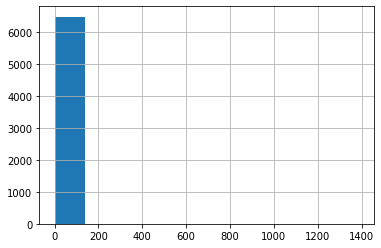

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count